In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report , ConfusionMatrixDisplay , confusion_matrix

In [2]:
# Define labels for classificcation
labels = ['non-vehicles', 'vehicles']

In [3]:
# Read image folder
directory ='./data'

In [4]:
# Create TRAINING dataset (80%)

train_set = tf.keras.utils.image_dataset_from_directory(
  directory,
  validation_split=0.2,
  subset="training",
  image_size=(75,75),
  class_names = labels,
  seed=1,
  label_mode = 'categorical',
  batch_size=32)


Found 17760 files belonging to 2 classes.
Using 14208 files for training.


In [5]:
# Create VALIDATION dataset (20%)

val_set = tf.keras.utils.image_dataset_from_directory(
  directory,
  validation_split=0.2,
  subset="validation",
  seed=1,
  class_names = labels,
  label_mode = 'categorical',
  image_size=(75,75),
  batch_size=32)


Found 17760 files belonging to 2 classes.
Using 3552 files for validation.


/var/folders/hq/hpdjlgpn3lb4tkwd5ckxz9cw0000gn/T/ipykernel_81713/2887092708.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,6,j+1)


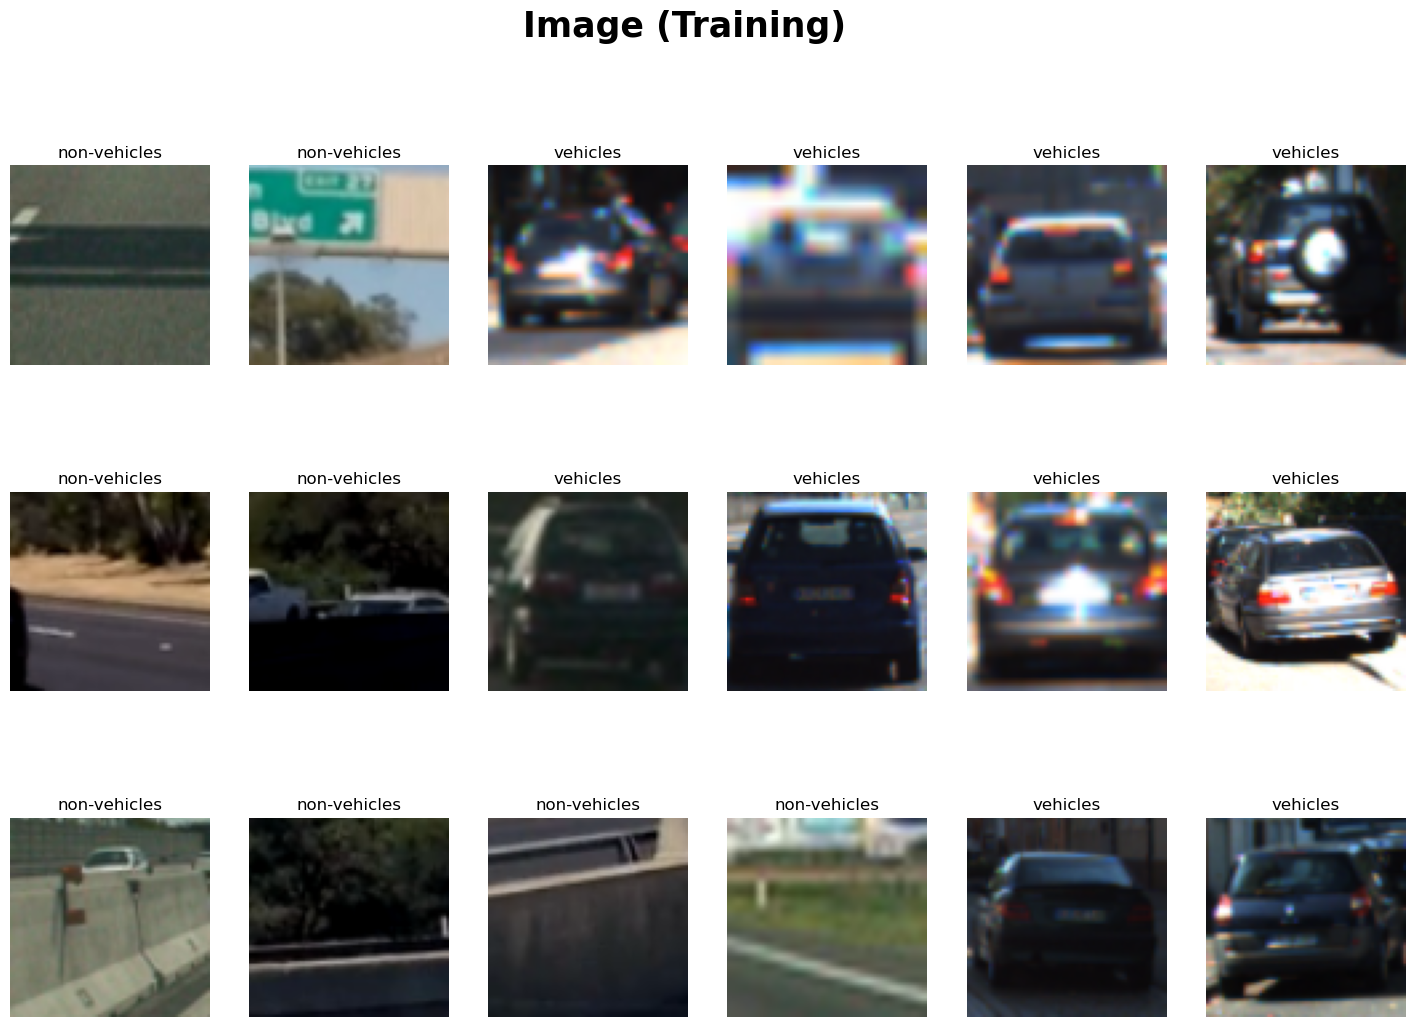

In [6]:
# Display image from Training dataset

n_images = 18
fig , axs = plt.subplots(figsize = (18,12))
fig.suptitle('Image (Training)', fontweight = 'bold' , fontsize = 25 , ha = 'center')
for img , label in train_set.take(1):
    for j in range(n_images):
        plt.subplot(3,6,j+1)
        plt.title(labels[np.argmax(label[j])])
        plt.imshow(img[j]/255.0)
        plt.axis('off')
    break
    

# Image Processing

In [7]:
# Split into TRAINING and TESTING (90-10)

import tensorflow as tf

DATASET_SIZE = len(list(train_set))
train_size = int(0.9 * DATASET_SIZE)
test_size = DATASET_SIZE - train_size
dataset = train_set.shuffle(buffer_size=DATASET_SIZE)

train_set = dataset.take(train_size)
test_set = dataset.skip(train_size)

In [8]:
# check For splitting
print(f'Training = {train_set.cardinality().numpy()}\nValidation = {val_set.cardinality().numpy()}\nTesting = {test_set.cardinality().numpy()}')

Training = 399
Validation = 111
Testing = 45


In [9]:
# Rescaling
def rescaling(image , label):
    return image/255.0 , label

In [10]:
train_set = train_set.map(rescaling)
val_set = val_set.map(rescaling)
test_set = test_set.map(rescaling)

In [11]:
# Augmenting
def augment_data(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_hue(image , max_delta = 0.5)
    return image ,label

In [12]:
train_set = train_set.map(augment_data)

In [13]:
# Prefetching
train_set = train_set.prefetch(tf.data.AUTOTUNE)
val_set = val_set.prefetch(tf.data.AUTOTUNE)
test_set = test_set.prefetch(tf.data.AUTOTUNE)

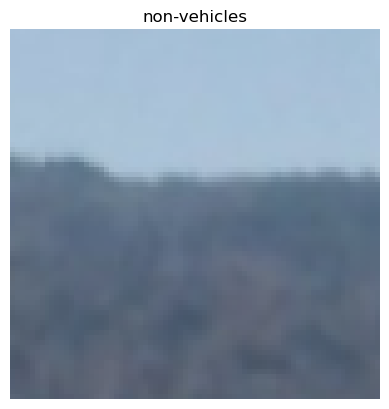

In [14]:
for img , label in test_set.take(3):
    plt.title(labels[np.argmax(label[10])])
    plt.imshow(img[10])
    plt.axis('off')
    break

# Modelling

In [15]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, Dropout

back_bone  = tf.keras.applications.InceptionV3(include_top = False , input_shape = (75,75,3))
back_bone.trainable = False
model = tf.keras.Sequential([
    back_bone,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, kernel_regularizer=regularizers.l2(l=0.001), 
                          activity_regularizer=regularizers.l1(0.001),
                          bias_regularizer=regularizers.l1(0.001), activation='relu'),
    Dropout(rate=0.2, seed=123),
    tf.keras.layers.Dense(len(labels), activation='sigmoid')
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 batch_normalization_94 (Ba  (None, 1, 1, 2048)        8192      
 tchNormalization)                                               
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1

In [16]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer = Adam(learning_rate=0.0001) , 
              loss = tf.keras.losses.BinaryCrossentropy() ,metrics = ['accuracy'] )

# Training 

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=3,        
    verbose=1,
    restore_best_weights=True
)

history = model.fit(train_set , validation_data = val_set , epochs = 10, 
          steps_per_epoch=train_set.cardinality().numpy(),
          validation_steps=val_set.cardinality().numpy())

Epoch 1/10
399/399 [==============================] - 27s 62ms/step - loss: 0.4325 - accuracy: 0.9066 - val_loss: 0.2653 - val_accuracy: 0.9761
Epoch 2/10
399/399 [==============================] - 27s 66ms/step - loss: 0.2707 - accuracy: 0.9638 - val_loss: 0.2149 - val_accuracy: 0.9825
Epoch 3/10
399/399 [==============================] - 28s 68ms/step - loss: 0.2424 - accuracy: 0.9668 - val_loss: 0.1933 - val_accuracy: 0.9842
Epoch 4/10
399/399 [==============================] - 27s 65ms/step - loss: 0.2183 - accuracy: 0.9725 - val_loss: 0.1762 - val_accuracy: 0.9859
Epoch 5/10
399/399 [==============================] - 26s 65ms/step - loss: 0.1971 - accuracy: 0.9768 - val_loss: 0.1608 - val_accuracy: 0.9887
Epoch 6/10
399/399 [==============================] - 27s 66ms/step - loss: 0.1863 - accuracy: 0.9768 - val_loss: 0.1503 - val_accuracy: 0.9876
Epoch 7/10
399/399 [==============================] - 28s 69ms/step - loss: 0.1738 - accuracy: 0.9767 - val_loss: 0.1402 - val_accuracy:

# Evaluation

In [18]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_set)
print('\nTest accuracy:', test_acc)

45/45 [==============================] - 3s 58ms/step - loss: 0.1114 - accuracy: 0.9924

Test accuracy: 0.9923611283302307


# Training history

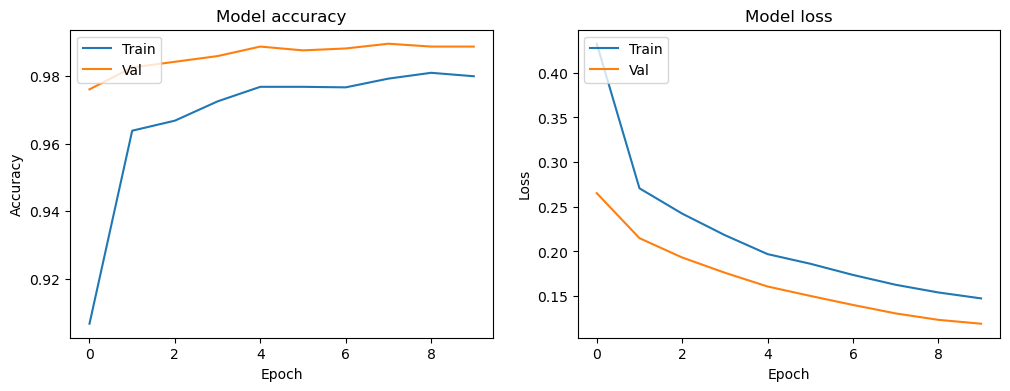

In [19]:
plt.figure(figsize=(12, 4))

# Plot training & validation ACCURACY values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation LOSS values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()


# Prediction

In [21]:
predictions = model.predict(test_set)

# Convert probabilities to class labels
pred_classes = np.argmax(predictions, axis=1)

45/45 [==============================] - 8s 128ms/step


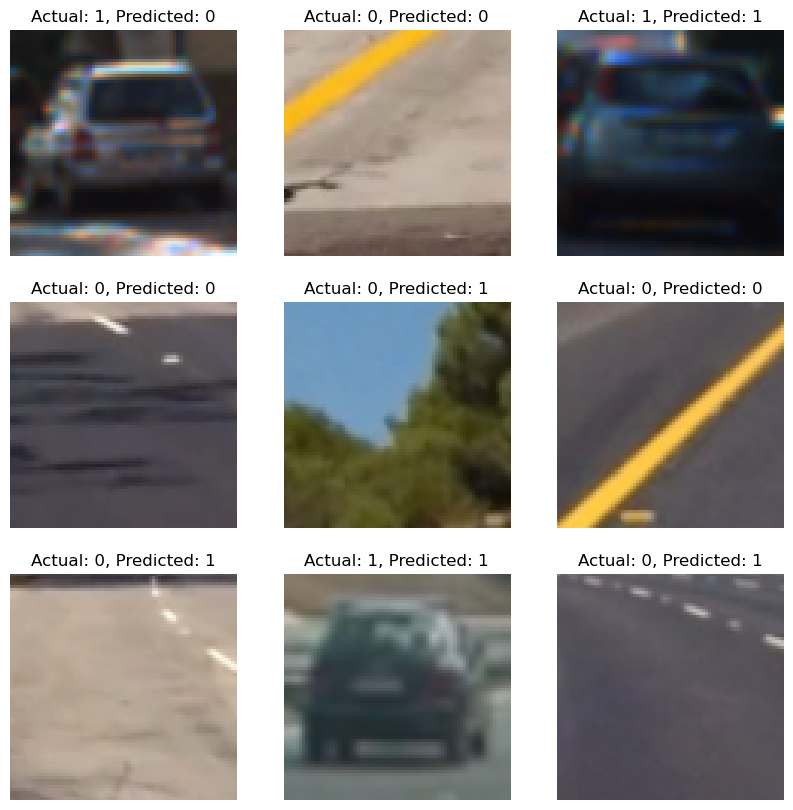

In [22]:
# Display prediction
plt.figure(figsize=(10, 10))
for images, labels in test_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy()
        if img.max() <= 1.0:  
            img = (img * 255).astype("uint8")
        else:  
            img = img.astype("uint8")
        plt.imshow(img)
        plt.title(f"Actual: {np.argmax(labels[i])}, Predicted: {pred_classes[i]}")
        plt.axis("off")


In [23]:
# Generate actual labels from the test set
actual_labels = np.concatenate([y for x, y in test_set], axis=0)
actual_classes = np.argmax(actual_labels, axis=1)
labels = ['non-vehicles', 'vehicles']

# Classification report
print(classification_report(actual_classes, pred_classes, target_names=labels))


              precision    recall  f1-score   support

non-vehicles       0.50      0.50      0.50       715
    vehicles       0.50      0.50      0.50       725

    accuracy                           0.50      1440
   macro avg       0.50      0.50      0.50      1440
weighted avg       0.50      0.50      0.50      1440



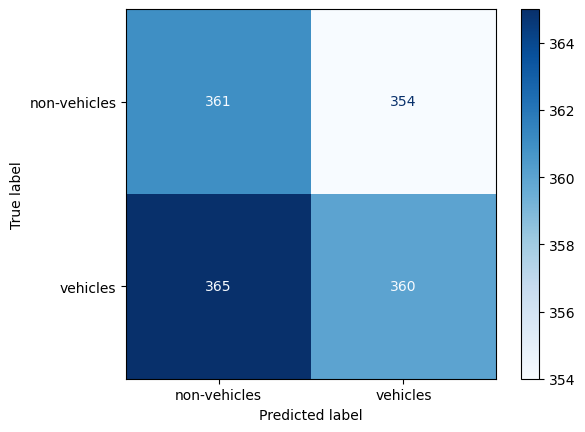

In [24]:
# Confusion Matrix
cm = confusion_matrix(actual_classes, pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
labels = ['non-vehicles', 'vehicles']

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
Model.save('vehicle_classification_model_ICT.h5')
